In [113]:
import os

import astropy.table as at
from astropy.constants import G
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import tables as tb

from gala.mpl_style import laguna, hesperia
from twobody.transforms import PeKi_to_a

from hq.config import Config
from hq.data import get_rvdata
from hq.physics_helpers import period_at_surface, stellar_radius

In [12]:
figure_path = '../../tex/figures'
os.makedirs(figure_path, exist_ok=True)

In [13]:
c = Config.from_run_name('dr16-random')

In [49]:
gold = at.QTable(at.Table.read('../../catalogs/gold_sample.fits').filled())
bimodal = at.Table.read('../../catalogs/bimodal.fits').filled()
bimodal = at.QTable(bimodal[bimodal['LOGG'] > -0.5], masked=False)

In [45]:
len(gold), len(bimodal)//2

(1032, 492)

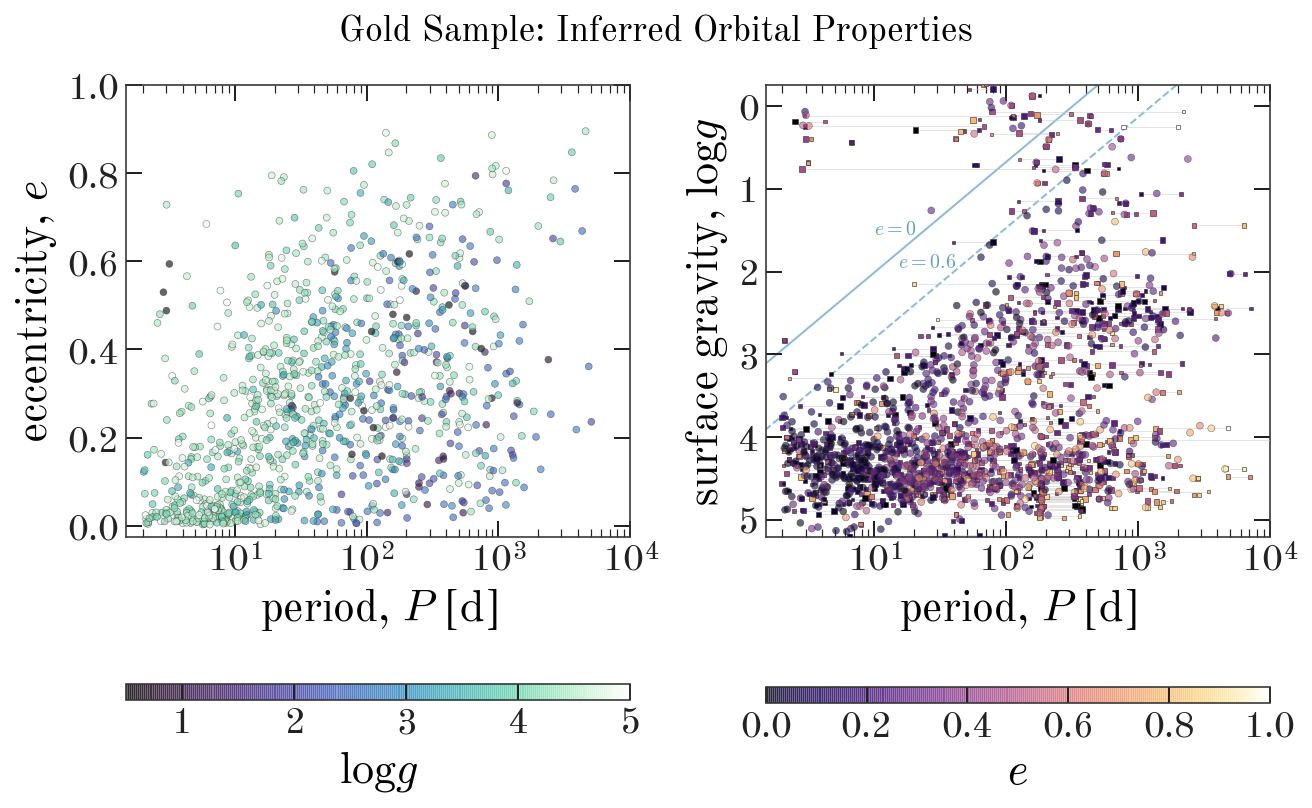

In [157]:
style = dict(s=12, lw=0.3, 
             edgecolor='#333333',
             alpha=0.6, zorder=10)

bi_style = dict(lw=0.3, marker='s', zorder=5, 
                edgecolor='#333333')

fig, axes = plt.subplots(1, 2, figsize=(9, 5.5), sharex=True, 
                         constrained_layout=True)

ax = axes[1]
im1 = ax.scatter(gold['MAP_P'], gold['LOGG'], 
           c=gold['MAP_e'], vmin=0, vmax=1, 
           cmap='hesperia',
           **style)

# TODO: do we want to show the bimodal on here?
for i in [0, 1]:
    ax.scatter(bimodal['MAP_P'][i::2],
               bimodal['LOGG'][i::2],
               c=bimodal['MAP_e'][i::2],
               s=((1 + bimodal['bimodal_mode_fraction'][i::2]) * 1.5)**2,
               cmap='hesperia',
               **bi_style)

ax.plot(np.stack((bimodal['MAP_P'][::2].value, 
                  bimodal['MAP_P'][1::2].value)), 
        np.stack((bimodal['LOGG'][::2], 
                  bimodal['LOGG'][1::2])), 
        marker='', linestyle='-', alpha=0.5, 
        color='#cccccc', zorder=3, linewidth=0.5)

logg_grid = np.linspace(-0.5, 6, 128)
M2 = 0.3 * u.Msun
M1 = 1.1 * u.Msun
for e, ls in zip([0., 0.6], ['-', '--']):
    ax.plot(period_at_surface(M1, logg_grid, e=e, M2=M2),
            logg_grid, 
            marker='', zorder=-10, alpha=0.5,
            color='tab:blue', lw=1., ls=ls)

ax.text(21, 1.6, '$e=0$', ha='right', va='bottom', color='tab:blue', alpha=0.7)
ax.text(42, 2, '$e=0.6$', ha='right', va='bottom', color='tab:blue', alpha=0.7)
    
ax.set_ylabel(r'surface gravity, $\log g$')
ax.set_xscale('log')
ax.set_ylim(5.2, -0.25)

ax = axes[0]
im2 = ax.scatter(gold['MAP_P'], gold['MAP_e'], 
           c=gold['LOGG'], vmin=0.5, vmax=5, 
           cmap='laguna',
           **style)

# for i in [0, 1]:
#     ax.scatter(bimodal['MAP_P'][i::2],
#                bimodal['MAP_e'][i::2],
#                c=bimodal['LOGG'][i::2],
#                s=((1 + bimodal['bimodal_mode_fraction'][i::2]) * 1.5)**2,
#                cmap='laguna',
#                **bi_style)

# ax.plot(np.stack((bimodal['MAP_P'][::2].value, 
#                   bimodal['MAP_P'][1::2].value)), 
#         np.stack((bimodal['MAP_e'][::2].value, 
#                   bimodal['MAP_e'][1::2].value)), 
#         marker='', linestyle='-', alpha=0.5, 
#         color='#cccccc', zorder=3, linewidth=0.5)

ax.set_ylabel(r'eccentricity, $e$')
ax.set_xscale('log')
ax.set_ylim(-0.025, 1)

for ax in axes:
    ax.set_xlabel(f'period, $P$ [{u.day:latex_inline}]')
    ax.set_xticks(10 ** np.arange(0, 4+1e-3))
    ax.set_xticks(np.concatenate([[j * 10**i for j in range(1, 10)] 
                                  for i in np.arange(0, 4+1e-3)]),
                  minor=True)
    ax.set_xlim(1.5, 1e4)
    
cb1 = fig.colorbar(im1, ax=axes[1], orientation='horiztontal', pad=0.07)
cb1.set_label('$e$')
cb1.set_ticks(np.arange(0, 1+1e-3, 0.2))

cb2 = fig.colorbar(im2, ax=axes[0], orientation='horiztontal', pad=0.07)
cb2.set_label(r'$\log g$')
cb2.set_ticks(np.arange(0, 5+1e-3, 1))

fig.suptitle('Gold Sample: Inferred Orbital Properties', fontsize=18)

fig.savefig(os.path.join(figure_path, 'Plogg_Pe.pdf'), dpi=250)

## M2_min plots

In [6]:
# COPIED FROM: Figure-highmass-lowmass.ipynb
low_mass_fav_ids = [
    '2M04394882-7514363',
    '2M13500861+3249553',
    '2M01083937+8550346',
    '2M17142443-2457219'
]

high_mass_fav_ids = [
    '2M13090983+1711572',
    '2M14332948+0958420',
    '2M13143277+1702017',
    '2M00574795+8502290'
]

fav_ids = low_mass_fav_ids + high_mass_fav_ids

highlight_mask = np.isin(gold['APOGEE_ID'].astype(str), fav_ids)
highlight_mask.sum()

8

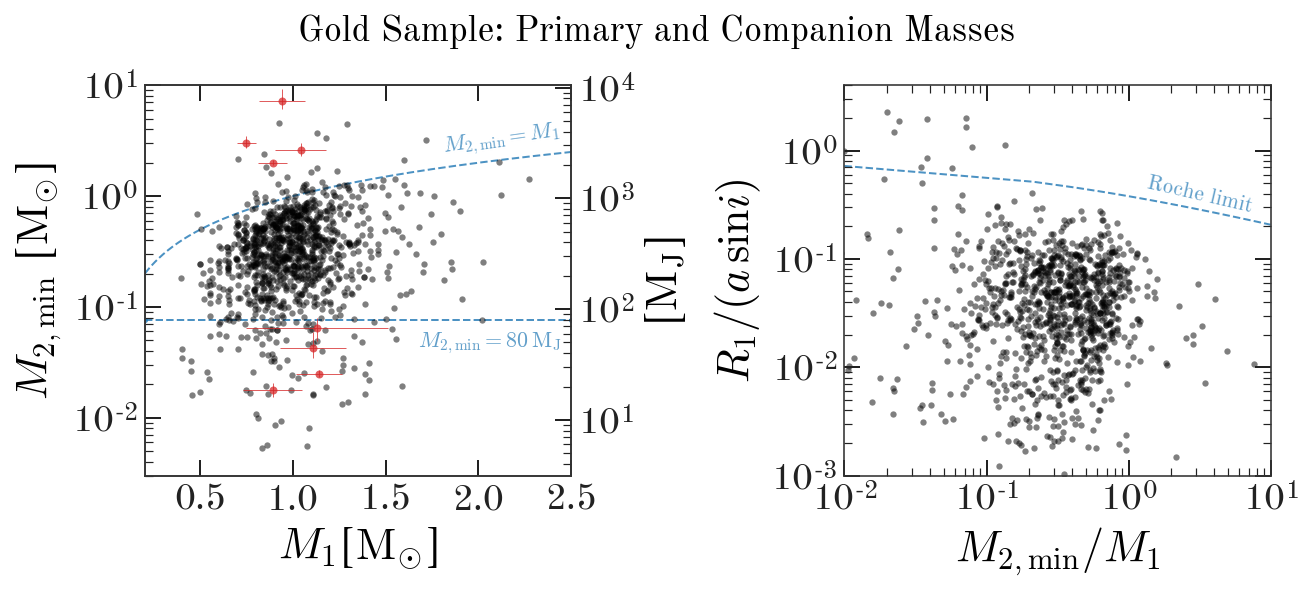

In [13]:
marker_style = dict(linewidth=0, s=10, alpha=0.5)
line_style = dict(zorder=-10, lw=1, color='tab:blue', 
                  linestyle='--', alpha=0.8)

fig, axes = plt.subplots(1, 2, figsize=(9, 4.),
                         constrained_layout=True)

ax = axes[0]

ax.scatter(gold['mass'][~highlight_mask], 
           gold['m2_min_50'].value[~highlight_mask], 
           **marker_style)

# Highlight stars picked for example high/low mass plots:
yerr = ((gold['m2_min_50'] - gold['m2_min_16']).value[highlight_mask],
        (gold['m2_min_84'] - gold['m2_min_50']).value[highlight_mask])
ax.errorbar(gold['mass'][highlight_mask], 
            gold['m2_min_50'].value[highlight_mask], 
            xerr=gold['mass_err'][highlight_mask],
            yerr=yerr, zorder=100, color='tab:red', ms=8,
            linestyle='', elinewidth=0.5, alpha=0.75)

mgrid = np.linspace(0.2, 2.5, 256)
ax.plot(mgrid, mgrid, marker='', **line_style)
ax.axhline((80*u.Mjup).to_value(u.Msun), 
           **line_style)

ax.set_xticks(np.arange(0.5, 2.5+1e-3, 0.5))

ax.set_xlim(0.2, 2.5)
ax.set_ylim(3e-3, 1e1)
ax.set_yscale('log')

ax.set_xlabel('$M_1$' + f'[{u.Msun:latex_inline}]')
ax.set_ylabel(r'$M_{2, {\rm min}}$ ' + f'[{u.Msun:latex_inline}]')

# Second y axis:
axr = ax.twinx()
ylim = ax.get_ylim()
axr.set_yscale('log')
axr.set_ylim((ylim[0]*u.Msun).to(u.Mjup).value, 
             (ylim[1]*u.Msun).to(u.Mjup).value)
axr.set_ylabel(f'[{u.Mjup:latex_inline}]')

ax.text(2.45, 2.1, r'$M_{2, {\rm min}} = M_1$', 
        ha='right', va='bottom', fontsize=11, 
        color='tab:blue', alpha=0.7, rotation=8)
ax.text(2.45, 0.062, r'$M_{2, {\rm min}} = 80\,{\rm M}_{\rm J}$', 
        ha='right', va='top', fontsize=11, 
        color='tab:blue', alpha=0.7)


# ------------------------------------

ax = axes[1]

qmin = gold['m2_min_50'].value / gold['mass']
Rstar = stellar_radius(gold['LOGG'], gold['mass']*u.Msun)
a1sini = PeKi_to_a(gold['MAP_P'], gold['MAP_e'], gold['MAP_K'])
asini = a1sini * (1 + 1/qmin)

ax.scatter(qmin, (Rstar/asini).decompose(), 
           **marker_style)

qgrid = np.linspace(1E-2, 1E1)
r1 = 0.49*qgrid**(-2/3.) / (0.6*qgrid**(-2/3.) + np.log(1+qgrid**(-1/3)))
ax.plot(qgrid, r1, marker='', **line_style)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks(10 ** np.arange(-2, 1+1e-3, 1))
ax.set_xticks(np.concatenate([[j * 10**i for j in range(1, 10)] 
                               for i in np.arange(-2, 1+1e-3)]),
              minor=True)

ax.set_xlim(1e-2, 1e1)
ax.set_ylim(1e-3, 4e0)

ax.text(1.3, 2.5e-1, 'Roche limit', rotation=-13,
        ha='left', va='bottom', fontsize=11, 
        color='tab:blue', alpha=0.7)

ax.set_xlabel(r'$M_{2, {\rm min}} / M_1$')
ax.set_ylabel(r'$R_1 / (a\,\sin i)$')

fig.suptitle('Gold Sample: Primary and Companion Masses', fontsize=18)

fig.savefig(os.path.join(figure_path, 'm2_m1_roche.pdf'), dpi=250)

## Slice in logg, plot P-e

In [172]:
bimodal_frac = np.stack((bimodal['bimodal_mode_fraction'][::2],
                         bimodal['bimodal_mode_fraction'][1::2])).T
bimodal_e = np.stack((bimodal['MAP_e'][::2].value,
                      bimodal['MAP_e'][1::2].value)).T
bimodal_e = np.array([x[j] for j, x in zip(np.argmax(bimodal_frac, axis=1), bimodal_e)])
bimodal_P = np.stack((bimodal['MAP_P'][::2].value,
                      bimodal['MAP_P'][1::2].value)).T
bimodal_P = np.array([x[j] for j, x in zip(np.argmax(bimodal_frac, axis=1), bimodal_P)])
bimodal_logg = bimodal['LOGG'][::2]

In [179]:
logg_bins = np.arange(1.25, 5.25+1e-3, 0.5)
len(logg_bins) - 1

8

In [180]:
logg_bins

array([1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25])

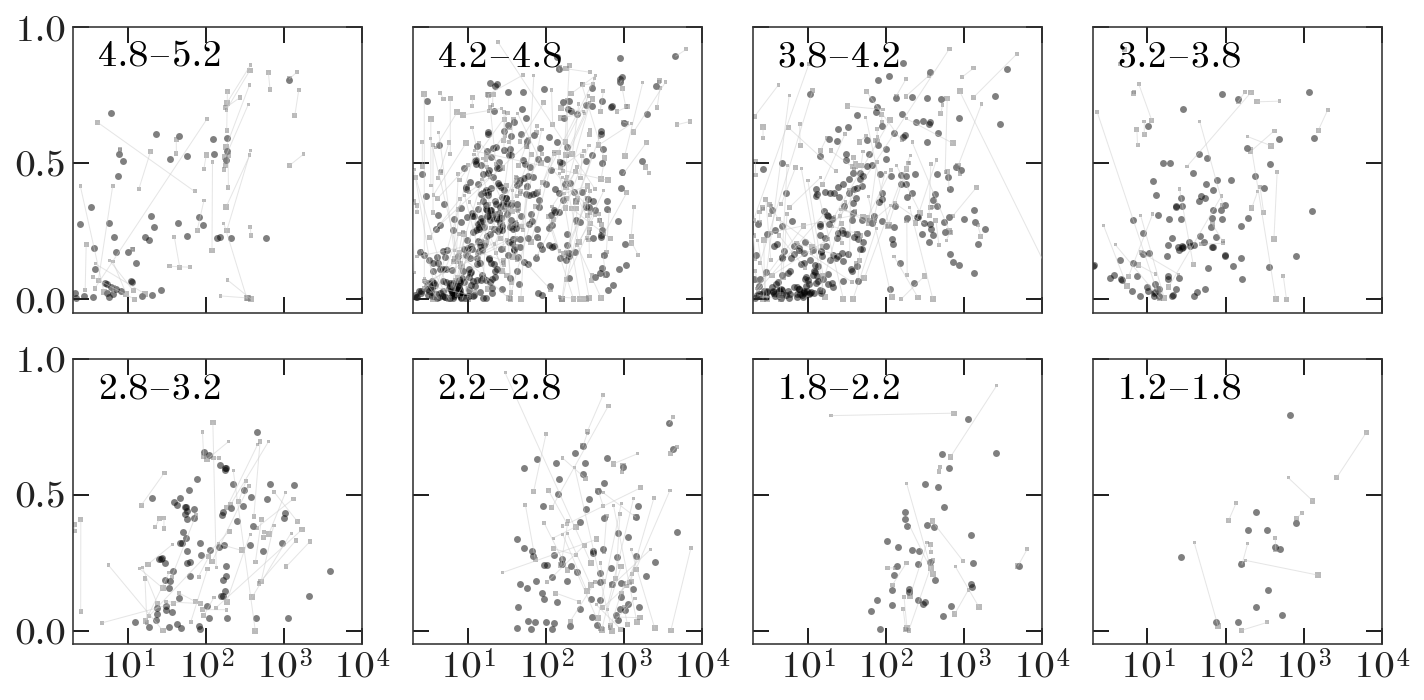

In [191]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5), 
                         sharex=True, sharey=True)

flat_axes = axes.flat[::-1]
for i in range(len(logg_bins)-1):
    ax = flat_axes[i]
    logg_l, logg_r = logg_bins[i], logg_bins[i+1]
    
    logg_mask = (gold['LOGG'] > logg_l) & (gold['LOGG'] <= logg_r)
    ax.scatter(gold['MAP_P'][logg_mask], 
               gold['MAP_e'][logg_mask], 
               lw=0, color='k', alpha=0.5, s=12)
    
    logg_mask = (bimodal['LOGG'] > logg_l) & (bimodal['LOGG'] <= logg_r)
    sub_bimodal = bimodal[logg_mask]
#     ax.scatter(bimodal_P[logg_mask], 
#                bimodal_e[logg_mask], 
#                lw=0, color='k', alpha=0.5, marker='s', s=12)
    for i in [0, 1]:
        ax.scatter(sub_bimodal['MAP_P'][i::2],
                   sub_bimodal['MAP_e'][i::2],
                   s=((1 + sub_bimodal['bimodal_mode_fraction'][i::2]) * 1.5)**2,
                   color='#777777', lw=0, alpha=0.5, marker='s')

    ax.plot(np.stack((sub_bimodal['MAP_P'][::2].value, 
                      sub_bimodal['MAP_P'][1::2].value)), 
            np.stack((sub_bimodal['MAP_e'][::2], 
                      sub_bimodal['MAP_e'][1::2])), 
            marker='', linestyle='-', alpha=0.5, 
            color='#cccccc', zorder=3, linewidth=0.5)
    
    ax.text(4, 0.95, f'{logg_l:.1f}–{logg_r:.1f}', 
            fontsize=18, va='top')
    
ax.set_xscale('log')
ax.set_xticks(10**np.arange(1, 4+1e-3, 1))
ax.set_xlim(2, 1e4)
ax.set_ylim(-0.05, 1)

fig.set_facecolor('w')
fig.tight_layout()

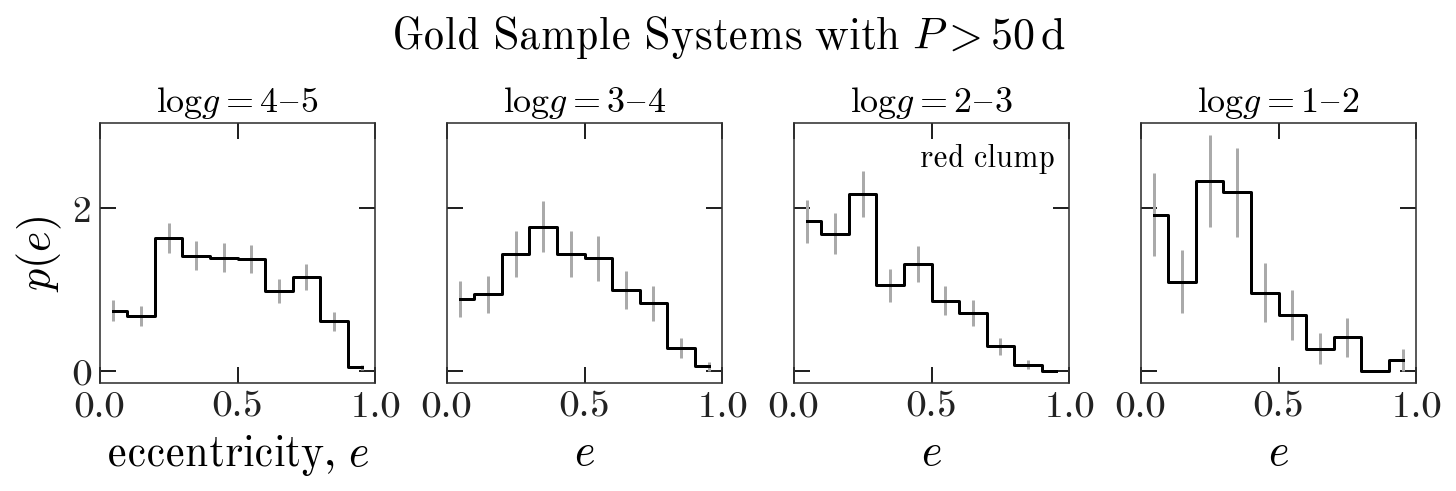

In [230]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3.3),
                         sharex=True, sharey=True,
                         constrained_layout=True)


logg_bins = [1., 2, 3, 4, 5]

for i in range(len(logg_bins)-1):
    ax = axes[::-1][i]
    logg_l, logg_r = logg_bins[i], logg_bins[i+1]
    
    logg_mask = (gold['LOGG'] > logg_l) & (gold['LOGG'] <= logg_r)
    P_mask = (gold['MAP_P'] > 50*u.day)
    e1 = gold['MAP_e'][logg_mask & P_mask]
    
    logg_mask = (bimodal['LOGG'] > logg_l) & (bimodal['LOGG'] <= logg_r)
    P_mask = (bimodal['MAP_P'] > 50*u.day)
    e2 = bimodal['MAP_e'][logg_mask & P_mask]
    es = np.concatenate((e1, e2))
    
    H, xe = np.histogram(es, 
                         bins=np.linspace(0, 1, 11))
    V = xe[1:] - xe[:-1]
    xctr = 0.5 * (xe[:-1] + xe[1:])
#     ax.hist(np.concatenate((e1, e2)), 
#             bins=np.linspace(0, 1, 11), density=True)
    
    ax.errorbar(xctr, H/V/H.sum(), np.sqrt(H)/V/H.sum(),
                drawstyle='steps-mid', marker='',
                ecolor='#aaaaaa')
    
    ax.set_title(r'$\log g = ' + f'{logg_l:.0f}$–${logg_r:.0f}$', 
                 fontsize=18)
    
    ax.set_xlabel('$e$')
    
ax.set_xlabel('eccentricity, $e$')
ax.set_ylabel('$p(e)$')

axes[2].text(0.95, 2.8, 'red clump', 
             ha='right', va='top', fontsize=16)

ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1+1e-3, 0.5))

fig.set_facecolor('w')

fig.suptitle(r'Gold Sample Systems with $P > 50\,{\rm d}$', fontsize=22)

fig.savefig(os.path.join(figure_path, 'P_e_logg_bins.pdf'))

## Rejected from paper:

In [69]:
all_e = np.concatenate((gold['MAP_e'], bimodal_e))
all_P = np.concatenate((gold['MAP_P'].value, bimodal_P))
all_logg = np.concatenate((gold['LOGG'], bimodal_logg))

PP_mask = (all_P > 50) & (all_P < 250)
H1, xe = np.histogram(all_logg[(all_e < 0.05) & PP_mask], 
                      np.arange(0.5, 5.5+1e-3, 0.25))
H2, xe = np.histogram(all_logg[PP_mask], 
                      np.arange(0.5, 5.5+1e-3, 0.25))
xx = 0.5 * (xe[:-1] + xe[1:])

<ErrorbarContainer object of 3 artists>

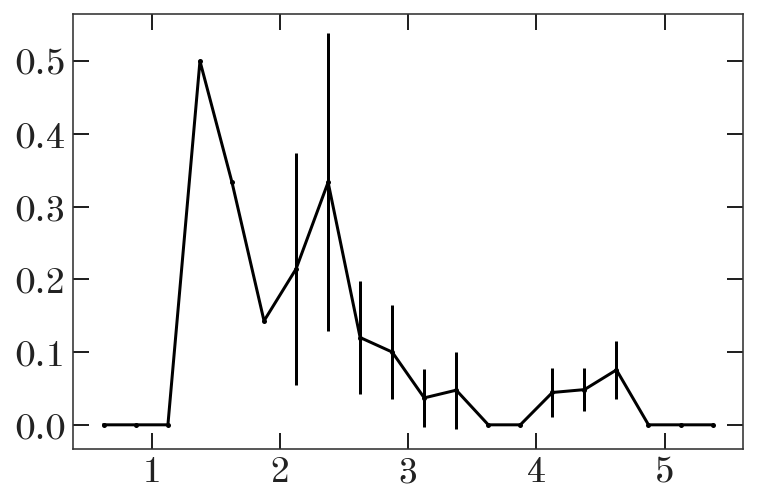

In [70]:
err = np.nanstd(np.random.poisson(H1, size=(10000, len(H1))) 
                / np.random.poisson(H2, size=(10000, len(H2))), 
                axis=0)
plt.errorbar(xx, H1 / H2, err)

In [72]:
from scipy.stats import binned_statistic

In [100]:
e_mask = (all_e < 0.1) & (all_logg > 0) & (all_logg < 5.5)

In [111]:
stat = binned_statistic(all_P[e_mask], 
                        all_logg[e_mask], 
                        bins=10**np.arange(0, 3+1e-3, 0.4),
                        statistic=np.median)
stat_ctr = 0.5*(stat.bin_edges[:-1] + stat.bin_edges[1:])

count, _ = np.histogram(all_P[e_mask], bins=stat.bin_edges)

In [112]:
count

array([ 15,  86, 113,  48,  24,  28,  35])

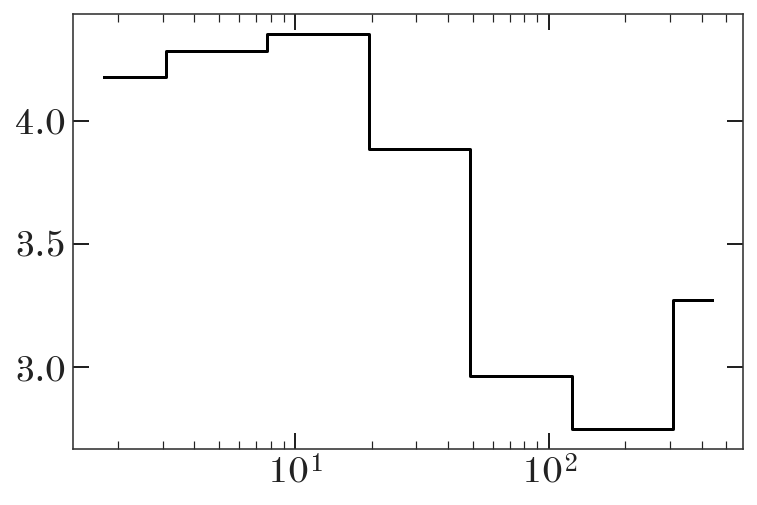

In [109]:
plt.errorbar(stat_ctr, stat.statistic, # stat_std.statistic,
             drawstyle='steps-mid', marker='')
plt.xscale('log')

Try plotting a vs. R instead:

In [126]:
from hq.physics_helpers import stellar_radius

In [128]:
R1 = stellar_radius(gold['LOGG'], gold['mass']*u.Msun)
a1 = PeKi_to_a(gold['MAP_P'], gold['MAP_e'], gold['MAP_K']).to(u.au)
q = gold['m2_min_50'].value / gold['mass']
a = a1 * (1 + 1/q)

(0.1, 1000.0)

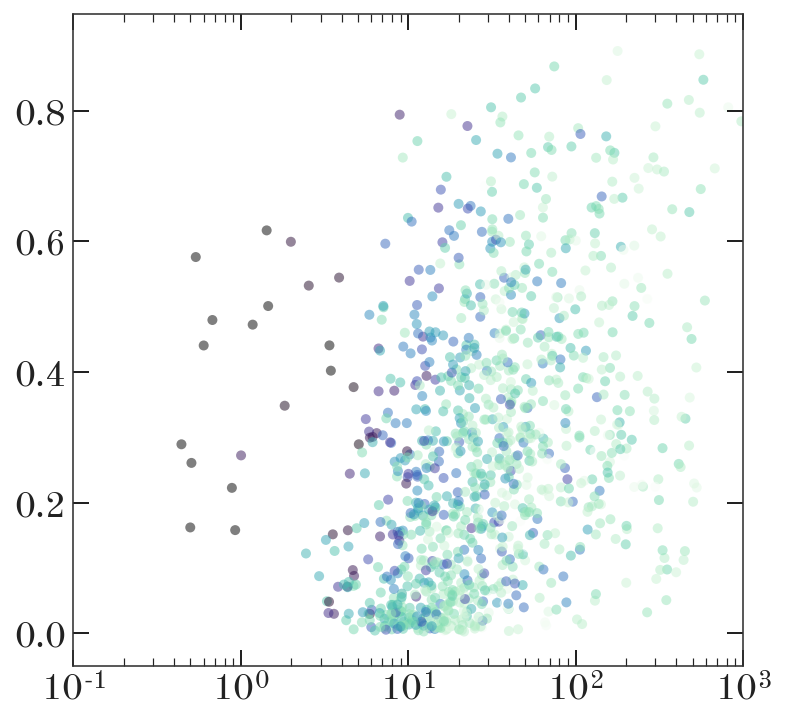

In [158]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.scatter(a.to_value(u.au),
#            a.to_value(u.Rsun) / R1.to_value(u.Rsun),
#            c=gold['MAP_e'],
#            marker='o', linewidth=0, alpha=0.5)

# ax.set_xscale('log')
# ax.set_yscale('log')

# # ax.set_xlim(1e-1, 3e3)
# ax.set_ylim(1e-1, 1e3)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(a.to_value(u.Rsun) / R1.to_value(u.Rsun),
           gold['MAP_e'],
           c=gold['LOGG'],
           vmin=0.5, vmax=5, 
           cmap='laguna',
           marker='o', linewidth=0, alpha=0.5)

# ax.set_xscale('log')
ax.set_xscale('log')

# ax.set_xlim(1e-1, 3e3)
ax.set_xlim(1e-1, 1e3)